In [2]:
from numpy import random 
import numpy as np 
import matplotlib.pyplot as plt

In [3]:
def mandelbrot(c,max_iters):
    counter=0
    threshold=2
    Z_now=complex(0,0)
    while(counter<max_iters):
        Z_next=pow(Z_now,2)+c
        if(abs(Z_next)>threshold):
            return counter
        Z_now=Z_next
        counter+=1
    return max_iters

In [4]:
def point_counter(x,y,max_iters):
    '''
    Function to count number of points in the Mandelbrot Set
    '''
    counter=0
    for i,x_i in enumerate(x):
        c=complex(x_i,y[i])
        check=mandelbrot(c,max_iters)
        if check==max_iters : counter+=1
    return counter


In [5]:
def area_estimate(x_range, y_range, max_iters, num_samples):
    x_samples = np.random.uniform(x_range[0], x_range[1], num_samples)
    y_samples = np.random.uniform(y_range[0], y_range[1], num_samples)
    mandelbrot_count = point_counter(x_samples, y_samples, max_iters)
    total_area = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])
    estimated_area = total_area * mandelbrot_count / num_samples
    return estimated_area

In [6]:
def create_grid(x,y,max_iters):
    X,Y=np.meshgrid(x,y)
    C=np.vectorize(complex)(X,Y) 
    Z=[]
    for row in C: 
        Z_row=[]  
        for c in row: 
            Z_row.append(mandelbrot(c,max_iters))
        Z.append(Z_row) 
    Z=np.array(Z)
    return Z


In [7]:
def plot_fractal(Z,x1,x2,y1,y2):
    plt.figure(figsize=(10,7))
    plt.imshow(Z,extent=(x1,x2,y1,y2),cmap='Blues_r',interpolation='bilinear')
    plt.colorbar(label='Iterations to escape')
    plt.title('Mandelbrot Set')
    plt.xlabel('Re(c)')
    plt.ylabel('Im(c)')
    plt.show()



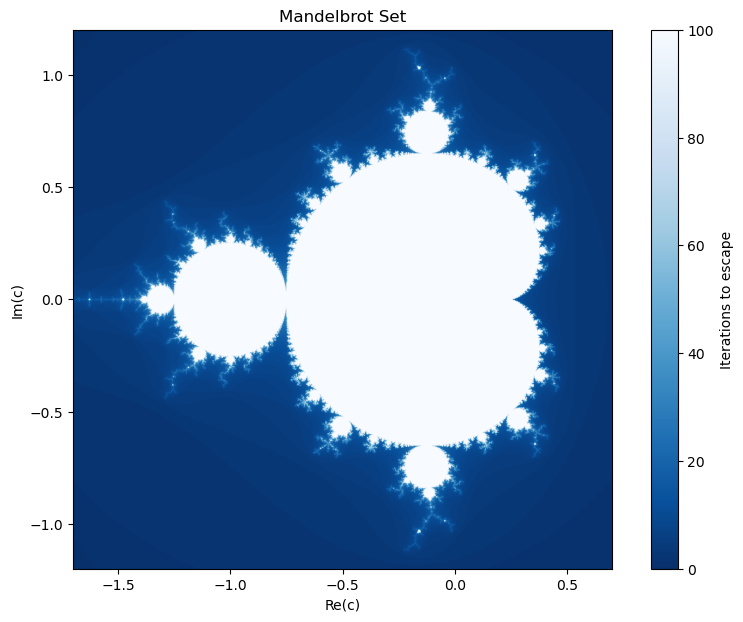

In [8]:
max_iters=100
n=1000
x=np.linspace(-1.7,0.7,n)  
y=np.linspace(-1.2,1.2,n)
plot_fractal(create_grid(x,y,max_iters),min(x),max(x),min(y),max(y))


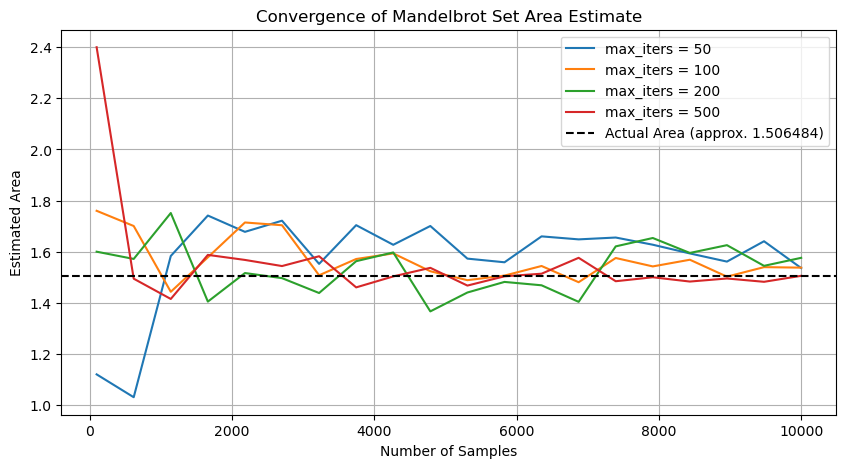

In [12]:
x_range = (-2,2)
y_range = (-2,2)
max_iters_list = [50, 100, 200, 500]
n_list = np.linspace(100, 10000, 20, dtype=int)
A_m = 1.506484

results = {} 

for max_iters in max_iters_list: 
    areas = []
    for n in n_list: 
        est_area = area_estimate(x_range, y_range, max_iters, n)
        areas.append(est_area)
    results[max_iters] = areas

plt.figure(figsize=(10, 5))

for max_iters, areas in results.items():
    plt.plot(n_list, areas, label=f"max_iters = {max_iters}", linestyle='-')

plt.axhline(A_m, linestyle='--', label="Actual Area (approx. 1.506484)", color="black")
plt.title("Convergence of Mandelbrot Set Area Estimate")
plt.xlabel("Number of Samples")
plt.ylabel("Estimated Area")
plt.legend()
plt.grid()
plt.show()
